<a href="https://colab.research.google.com/github/kevinyecs/Brats/blob/main/brats_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm ,einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%pip install git+https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git
%pip install "monai[einops]"
%matplotlib inline


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git to /tmp/pip-req-build-0lm_byld
  Running command git clone -q https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git /tmp/pip-req-build-0lm_byld
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install colorama
%pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TODO :


*   Load checkpoiting
*   Post proccess
*   Tranfer learning
*   More later







In [ ]:
import os
import shutil
import tempfile
import time
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt

from colorama import Fore, Back, Style
g_ = Fore.GREEN
c_ = Fore.CYAN
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

from ranger import Ranger

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss, GeneralizedWassersteinDiceLoss, DiceCELoss, DiceFocalLoss, TverskyLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet, UNet, UNETR, DynUNet, SwinUNETR
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    CropForegroundd
)
from monai.utils import set_determinism

import torch
import torch.nn as nn
import numpy as np

import json
import wandb

#print_config()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cur_time = datetime.now().strftime('%Y%m%d_%T').replace(":", "")

class Config(nn.Module):
    def __init__(self , max_epochs=42, batch_size=1, lr=1e-4, \
                scheduler=None, wd=0.0, backbone=None, optim="ranger", arch = "SegResNet", loss="dice"):
        self.exp_name       = cur_time + "_"+ str(arch)+ "_"+ str(max_epochs) + "_"+ str(batch_size) + \
                            "_"+ str(lr) + "_"+ str(wd) + "_"+ str(backbone) + "_"+ str(optim)  + "_"+ str(loss)
        self.loss = loss
        self.optim          = optim
        self.max_epochs     = max_epochs
        self.batch_size     = batch_size
        self.lr             = lr
        self.scheduler      = scheduler
        self.wd             = wd
        self.backbone       = backbone
        self.device         = "cuda" if torch.cuda.is_available() else "cpu"
        self.seed           = 42
        self.data_dir       = "/content/drive/MyDrive/brats"
        self.min_lr         = 1e-6
        self.T_max          = int(30000/batch_size* max_epochs)+50
        self.T_0            = 25
        self.n_accumulate   = max(1,64/batch_size)
        self.n_fold         = 5
        self.num_classes    = 3
        self.arch           = arch

cfg = Config(
    arch = "SwinUnet",
    loss="dice",
    optim="AdamW",
    
)
print("Used device :", cfg.device)
print("Exp name :", cfg.exp_name)
    

Used device : cuda
Exp name : 20221104_151859_SwinUnet_42_1_0.0001_0.0_None_AdamW_dice


In [ ]:
directory = cfg.data_dir
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/drive/MyDrive/brats


In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):

    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k, v in d.items():
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [ ]:
set_determinism(seed=cfg.seed)

In [ ]:
wandb.init(project="notebook")
wandb.login(key="10fb6ea2f20c6efb49af4a0ddda03a60aad9d6db")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kevinye (ky_thesis). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
wandb.config.update(cfg)
print('Training configuration: ', cfg.__dict__)

# Initialize W&B run
run = wandb.init(project='brats_experiments', 
                 config=cfg.__dict__,
                 group=f'{cfg.arch}', 
                 job_type='train')

Training configuration:  {'exp_name': '20221104_151859_SwinUnet_42_1_0.0001_0.0_None_AdamW_dice', 'loss': 'dice', 'optim': 'AdamW', 'max_epochs': 42, 'batch_size': 1, 'lr': 0.0001, 'scheduler': None, 'wd': 0.0, 'backbone': None, 'device': 'cuda', 'seed': 42, 'data_dir': '/content/drive/MyDrive/brats', 'min_lr': 1e-06, 'T_max': 1260050, 'T_0': 25, 'n_accumulate': 64.0, 'n_fold': 5, 'num_classes': 3, 'arch': 'SwinUnet'}


In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [ ]:

train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        CropForegroundd(
        keys=["image", "label"],
        source_key="image",
        k_divisible=[128,128,128],),
 
        RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [ ]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=1,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=False)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=1,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=False)

image shape: (4, 240, 240, 155)


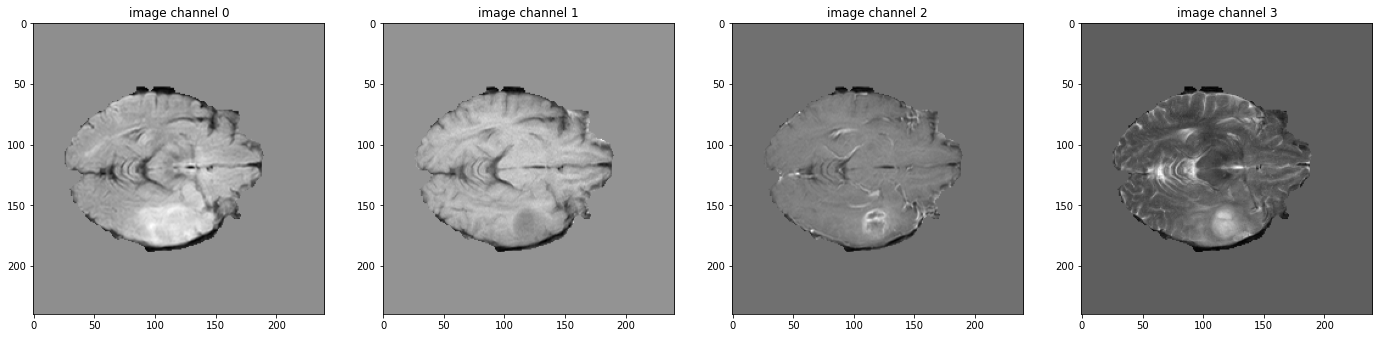

label shape: (3, 240, 240, 155)


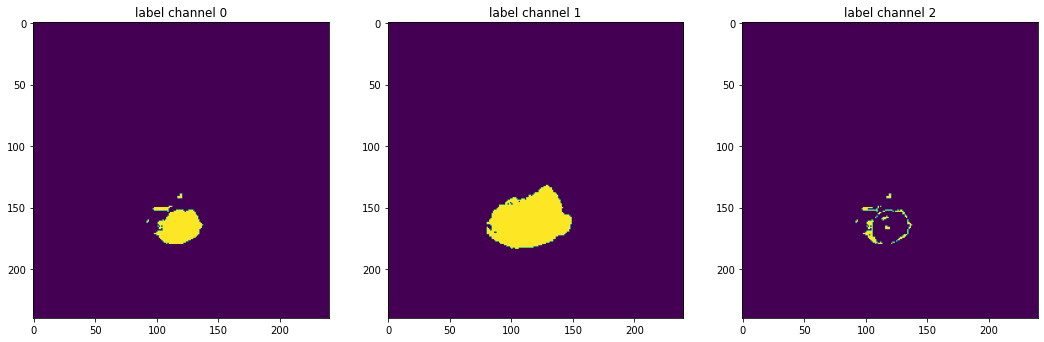

In [ ]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()


In [ ]:
roi = (224, 224, 144)
if cfg.arch == "SwinUnet":
  roi = (128, 128, 128)
max_epochs = cfg.max_epochs
val_interval = 1 #TODO: add to cfg
VAL_AMP = True 

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
if cfg.arch == "SegResNet":
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=4,
        out_channels=3,
        dropout_prob=0.2,
    ).to(device)

elif cfg.arch == "UNet":
    model = UNet(
        dimensions=3,
        in_channels=4,
        out_channels=3,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

elif cfg.arch == "VNet":
    pass

elif cfg.arch == "SwinUnet":
  model = SwinUNETR(
      img_size=roi,
      in_channels=4,
      out_channels=3,
      feature_size=48,
      drop_rate=0.0,
      attn_drop_rate=0.0,
      dropout_path_rate=0.0,
      use_checkpoint=True,
  ).to(device)



# Getting Loss Fucntion 
if cfg.loss == "dice":
    loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
elif cfg.loss == "CEDice":
    loss_function = DiceCELoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
elif cfg.loss == "Tversky":
    loss_function = TverskyLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
elif cfg.loss == "Focal":
    loss_function = DiceFocalLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
elif cfg.loss == "wasserstein":
    loss_function = GeneralizedWassersteinDiceLoss(sigmoid=True, include_background=False, square_pred=True)

# Getting Optimizer
if cfg.optim == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)

elif cfg.optim == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.wd)

elif cfg.optim == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.wd)

elif cfg.optim == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)

elif cfg.optim == "AdaGrad":
    optimizer = torch.optim.Adagrad(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)

elif cfg.optim == "ranger":
    optimizer = Ranger(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
    rangered = True
    
optimizer = Ranger(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
rangered = True
    

if cfg.scheduler == "ReduceLROnPlateau":
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

elif cfg.scheduler == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.max_epochs, eta_min=0)

elif cfg.scheduler == "CosineAnnealingWarmRestarts":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cfg.max_epochs, T_mult=1, eta_min=0)

elif cfg.scheduler == "OneCycleLR":
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cfg.lr, total_steps=cfg.max_epochs)

elif cfg.scheduler == "CyclicLR":
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=cfg.lr, max_lr=cfg.lr, cycle_momentum=False)

elif cfg.scheduler == "ExponentialLR":
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

elif cfg.scheduler == "StepLR":
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.max_epochs, gamma=0.1)
    
    #TODO : Add Poly lr 

#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Getting Scheduler



dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                               cfg.max_epochs + 30 if not rangered else round(
                                                                   cfg.max_epochs * 0.5))
post_trans = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

print("Used Net:", model)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Used Net: SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(4, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              

**Training**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history = defaultdict(list)
wandb.watch(model, log_freq=100)

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(cfg.max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(cfg.device),
            batch_data["label"].to(cfg.device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    history['Train Loss'].append(epoch_loss)
    history['Learning Rate'].append(optimizer.param_groups[0]['lr'])

    # Log the metrics
    wandb.log({"Train Loss": epoch_loss})
    
    

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(cfg.device),
                    val_data["label"].to(cfg.device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            history['Validation Loss'].append(epoch_loss)
            history['Validation Dice'].append(metric)
            history['Validation Dice TC'].append(metric_tc)
            history['Validation Dice WT'].append(metric_wt)
            history['Validation Dice ET'].append(metric_et)
            

            wandb.log({"Validation Loss": epoch_loss})
            wandb.log({"Validation Dice": metric})
            wandb.log({"Validation Dice TC": metric_tc})
            wandb.log({"Validation Dice WT": metric_wt})
            wandb.log({"Validation Dice ET": metric_et})




            if metric > best_metric:
                print(f"{c_}Validation Loss Improved ({best_metric} ---> {metric})")
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                wandb.save("/content/drive/MyDrive/brats/best_metric_model.pth")


                history['Best Validation Dice TC'].append(metric_tc)
                history['Best Validation Dice WT'].append(metric_wt)
                history['Best Validation Dice ET'].append(metric_et)
                history['Best Validation Dice'].append(best_metric)
                history['Best Validation Dice Epoch'].append(best_metric_epoch)
                history['Best Validation Dice Time'].append(time.time() - total_start)
                

                wandb.log({"Best Validation Dice TC": metric_tc})
                wandb.log({"Best Validation Dice WT": metric_wt})
                wandb.log({"Best Validation Dice ET": metric_et})

                wandb.log({"Best Validation Dice": best_metric})
                wandb.log({"Best Validation Dice Epoch": best_metric_epoch})
                wandb.log({"Best Validation Dice Epochs and Time": best_metrics_epochs_and_time})
                
                print("saved new best metric model {sr_}")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start



----------
epoch 1/42
1/388, train_loss: 0.9865, step time: 22.9921
2/388, train_loss: 0.9846, step time: 1.9261
3/388, train_loss: 0.8968, step time: 1.8892
4/388, train_loss: 0.9995, step time: 1.9262
5/388, train_loss: 0.9994, step time: 1.9224
6/388, train_loss: 0.9596, step time: 1.9701
7/388, train_loss: 0.7920, step time: 2.0048
8/388, train_loss: 0.9671, step time: 2.0529
9/388, train_loss: 0.9625, step time: 1.9966
10/388, train_loss: 0.7624, step time: 2.0169
11/388, train_loss: 0.9724, step time: 1.9415
12/388, train_loss: 0.9829, step time: 1.9809
13/388, train_loss: 0.8750, step time: 2.0299
14/388, train_loss: 0.9774, step time: 1.9829
15/388, train_loss: 0.9485, step time: 2.0304
16/388, train_loss: 0.8124, step time: 2.0130
17/388, train_loss: 0.7721, step time: 1.9951
18/388, train_loss: 0.9392, step time: 2.0236
19/388, train_loss: 0.9377, step time: 2.0110
20/388, train_loss: 0.6867, step time: 2.0382
21/388, train_loss: 0.9499, step time: 2.0084
22/388, train_loss: 

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: .") #{total_time}

In [ ]:


plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

In [ ]:


model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()



In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")


run.finish()

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)